In [1]:
import pandas as pd
import pandas_ta as ta
from tqdm.auto import tqdm
import numpy as np
import json
import os

import pywt
from statsmodels.tsa.seasonal import STL
from joblib import Parallel, delayed



In [2]:
# --- ШАГ 1: ручная карта подтвержденных сплитов ---
def load_split_map(filepath: str) -> dict:
    """Загружает карту сплитов из JSON-файла."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            split_map = json.load(f)
        print(f"Карта сплитов успешно загружена из: {filepath}")
        return split_map
    except FileNotFoundError:
        print(f"Предупреждение: Файл с картой сплитов не найден по пути {filepath}. Корректировка не будет произведена.")
        return {}
    except json.JSONDecodeError:
        print(f"ОШИКА: Не удалось прочитать JSON-файл {filepath}. Проверьте его формат.")
        return {}
    

In [3]:
# # # --- # ToDo!!!! Не реализовано!!! пока что ошибка
# def generate_features_grouped(df, column='Close', group_col='Ticker', 
#                             fft_n=10, wavelet='db4', wavelet_level=3, 
#                             window=128, step=1):
#     all_feats = []

#     for ticker, group in df.groupby(group_col):
#         series = group[column]
#         index = group.index

#         feats = []
#         for i in range(window, len(series), step):
#             # seg = series[i-window:i].values
#             # seg = series[i-window:i].to_numpy(dtype=float)
#             seg = np.array(series[i-window:i], dtype=np.float64, copy=True)
#             ts_idx = index[i]

#             feat = {group_col: ticker}

#             # Фурье-признаки
#             fft_vals = np.fft.fft(seg)
#             fft_abs = np.abs(fft_vals[:fft_n])
#             for j in range(fft_n):
#                 feat[f'fft_{j}'] = fft_abs[j]

#             # Вейвлет-признаки
#             coeffs = pywt.wavedec(seg, wavelet=wavelet, level=wavelet_level)
#             for j, c in enumerate(coeffs):
#                 feat[f'wv_L{j}_energy'] = np.sum(np.square(c))
#                 feat[f'wv_L{j}_std'] = np.std(c)
#                 feat[f'wv_L{j}_mean'] = np.mean(c)

#             # STL-декомпозиция
#             stl = STL(seg, period=14)
#             res = stl.fit()
#             feat['stl_trend_last'] = res.trend[-1]
#             feat['stl_seasonal_last'] = res.seasonal[-1]
#             feat['stl_resid_last'] = res.resid[-1]

#             feats.append((ts_idx, feat))

#         # Превращаем в DataFrame
#         feature_df = pd.DataFrame([f[1] for f in feats], index=[f[0] for f in feats])
#         all_feats.append(feature_df)

#     # Объединяем все тикеры
#     return pd.concat(all_feats)



import numpy as np
import pandas as pd
import pywt
from statsmodels.tsa.seasonal import STL

# ==========================================================
# ВСПОМОГАТЕЛЬНАЯ ФУНКЦИЯ: извлечение признаков из сегмента
# ==========================================================
def extract_transformations_features(seg, fft_n=10, wavelet="db4", wavelet_level=3, stl_period=14):
    feat = {}
    
    seg = np.array(seg, dtype=float).copy()

    # --- Фурье ---
    fft_vals = np.fft.fft(seg)
    fft_abs = np.abs(fft_vals[:fft_n])
    for i, val in enumerate(fft_abs):
        feat[f'fft_abs_{i}'] = val

    # --- Вейвлет ---
    coeffs = pywt.wavedec(seg, wavelet=wavelet, level=wavelet_level)
    for j, c in enumerate(coeffs):
        feat[f'wv_L{j}_energy'] = np.sum(np.square(c))
        feat[f'wv_L{j}_std'] = np.std(c)
        feat[f'wv_L{j}_mean'] = np.mean(c)

    # --- STL ---
    try:
        stl = STL(seg, period=stl_period, robust=True)
        res = stl.fit()
        feat['stl_trend_last'] = res.trend[-1]
        feat['stl_seasonal_last'] = res.seasonal[-1]
        feat['stl_resid_last'] = res.resid[-1]
    except Exception:
        feat['stl_trend_last'] = np.nan
        feat['stl_seasonal_last'] = np.nan
        feat['stl_resid_last'] = np.nan

    return feat


# -------------------
# обработка одного тикера
# -------------------
def _transformations_process_one_group(grp, ticker, column, fft_n, wavelet, wavelet_level, stl_period, window, step):
    grp = grp.sort_values("Date").reset_index(drop=True)
    feats = pd.DataFrame(index=grp.index)

    for i in range(window, len(grp), step):
        seg = grp[column].iloc[i-window:i].values
        feat = extract_transformations_features(seg, fft_n=fft_n, wavelet=wavelet,
                                wavelet_level=wavelet_level, stl_period=stl_period)
        for k, v in feat.items():
            feats.loc[i, k] = v

    feats["Ticker"] = ticker
    feats["Date"] = grp["Date"]
    print(f"transformations done -> {ticker}")
    return feats



# -------------------
# главная функция с параллелью
# -------------------
def generate_transformations_features_grouped(df, column='Close', group_col='Ticker',
                              fft_n=10, wavelet='db4', wavelet_level=3,
                              window=128, step=1, stl_period=14, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(_transformations_process_one_group)(
            grp, ticker, column, fft_n, wavelet, wavelet_level, stl_period, window, step
        )
        for ticker, grp in df.groupby(group_col)
    )

    feature_df = pd.concat(results, ignore_index=True)
    return feature_df

In [4]:
# ==============================================================================
# РАСШИРЕННЫЙ ФИЧАИНЖИНИРИНГ (ПОЛНАЯ ИНТЕГРИРОВАННАЯ ВЕРСИЯ)
# ==============================================================================

def add_features_extended(df: pd.DataFrame, split_map: dict):
    """
    Добавляет в DataFrame расширенный набор технических индикаторов и статистических признаков.
    """
    print("Начало расширенного фичаинжиниринга...")
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

    # --- 1. Признаки тренда (Trend Features) ---
    print("Расчет индикаторов тренда...")
    sma_periods = [3, 5, 7, 10, 15, 20, 30, 40, 50, 70, 100, 150, 200]
    for i in sma_periods:
        df[f"sma_{i}"] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(i).mean())

    macd = df.groupby('Ticker', group_keys=False).apply(lambda x: ta.macd(x['Close'], fast=12, slow=26, signal=9))
    df = pd.concat([df, macd], axis=1)
    adx = df.groupby('Ticker', group_keys=False).apply(lambda x: ta.adx(x['High'], x['Low'], x['Close'], length=14))
    df = pd.concat([df, adx], axis=1)

    # --- 2. Признаки моментума (Momentum Features) ---
    print("Расчет индикаторов моментума...")
    rsi_periods = [5, 7, 14, 21, 30, 50]
    for i in rsi_periods:
        df[f"rsi_{i}"] = df.groupby('Ticker')['Close'].transform(lambda x: ta.rsi(x, length=i))

    stoch = df.groupby('Ticker', group_keys=False).apply(lambda x: ta.stoch(x['High'], x['Low'], x['Close'], k=14, d=3, smooth_k=3))
    df = pd.concat([df, stoch], axis=1)
    willr_periods = [5, 7, 14, 21, 30]
    for i in willr_periods:
        df[f"willr_{i}"] = df.groupby('Ticker', group_keys=False).apply(lambda x: ta.willr(x['High'], x['Low'], x['Close'], length=i))

    # --- 3. Признаки волатильности (Volatility Features) ---
    print("Расчет индикаторов волатильности...")
    atr_periods = [5, 7, 14, 21]
    for i in atr_periods:
        atr = df.groupby('Ticker', group_keys=False).apply(lambda x: ta.atr(x['High'], x['Low'], x['Close'], length=i))
        df[f"atr_{i}"] = atr

    bollinger = df.groupby('Ticker', group_keys=False).apply(lambda x: ta.bbands(x['Close'], length=20, std=2))
    
    df = pd.concat([df, bollinger], axis=1)
    df['bb_width_norm'] = (df['BBU_20_2.0_2.0'] - df['BBL_20_2.0_2.0']) / (df['BBM_20_2.0_2.0'] + 1e-9)

    # --- 4. Признаки объема (Volume Features) ---
    print("Расчет индикаторов объема...")
    vol_sma_periods = [5, 7, 14, 20, 30]
    for i in vol_sma_periods:
        df[f"vol_sma_{i}"] = df.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(i).mean())
        df[f'relative_volume_{i}'] = df['Volume'] / (df[f"vol_sma_{i}"] + 1e-9)

    print("Расчет и нормализация OBV...")
    obv_series = df.groupby('Ticker', group_keys=False).apply(lambda x: ta.obv(x['Close'], x['Volume']))
    df['obv'] = obv_series 
    for i in vol_sma_periods:
        obv_sma_col = f'obv_sma_{i}'
        df[obv_sma_col] = df.groupby('Ticker')['obv'].transform(lambda x: x.rolling(i).mean())
        # df[f'obv_relative_{i}'] = df['obv'] / (df[obv_sma_col] + 1e-9)
        df[f'obv_relative_{i}'] = df.groupby('Ticker')['obv'].transform(
            lambda x: (x - x.rolling(i).mean()) / (x.rolling(i).std() + 1e-9)
        )
        # df[f'obv_trend_{i}'] = df['obv'] - df[obv_sma_col]
        df[f'obv_momentum_{i}'] = df.groupby('Ticker')[f'obv_sma_{i}'].transform(
            lambda x: (x - x.shift(i)) / (x.shift(i).abs() + 1e-9)
        )



    df['turnover'] = df['Close'] * df['Volume']
    for i in vol_sma_periods: # Используем те же периоды для сопоставимости
        df[f"turnover_sma_{i}"] = df.groupby('Ticker')['turnover'].transform(lambda x: x.rolling(i).mean())
        df[f'relative_turnover_{i}'] = df['turnover'] / (df[f"turnover_sma_{i}"] + 1e-9)
    df.drop(columns=['turnover'], inplace=True)

    # --- 5. Признаки свечей и меж-дневной динамики ---
    print("Расчет признаков свечей и меж-дневной динамики...")
    df['day_range_norm'] = (df['High'] - df['Low']) / (df['Close'] + 1e-9)
    df['intraday_move_norm'] = (df['Close'] - df['Open']) / (df['Close'] + 1e-9)
    df['upper_wick_norm'] = (df['High'] - df[['Open', 'Close']].max(axis=1)) / (df['Close'] + 1e-9)
    df['lower_wick_norm'] = (df[['Open', 'Close']].min(axis=1) - df['Low']) / (df['Close'] + 1e-9)
    df['overnight_gap_norm'] = (df['Open'] - df.groupby('Ticker')['Close'].shift(1)) / (df.groupby('Ticker')['Close'].shift(1) + 1e-9)
    daily_range = df['High'] - df['Low']
    df['range_expansion_ratio'] = daily_range / (df.groupby('Ticker')['High'].shift(1) - df.groupby('Ticker')['Low'].shift(1) + 1e-9)

    # --- 6. Признаки взаимодействия Цены и Объема ---
    print("Расчет признаков взаимодействия Цены и Объема...")
    # Используем relative_volume_20, так как он соответствует периоду Bollinger Bands
    df['volume_weighted_move'] = df['intraday_move_norm'] * df['relative_volume_20']
    df['daily_return'] = df.groupby('Ticker')['Close'].pct_change()
    df['up_day_volume'] = df.apply(lambda row: row['Volume'] if row['daily_return'] > 0 else 0, axis=1)
    df['down_day_volume'] = df.apply(lambda row: row['Volume'] if row['daily_return'] <= 0 else 0, axis=1)
    
    sma_up_vol = df.groupby('Ticker')['up_day_volume'].transform(lambda x: x.rolling(20).mean())
    sma_down_vol = df.groupby('Ticker')['down_day_volume'].transform(lambda x: x.rolling(20).mean())
    df['up_down_volume_ratio'] = sma_up_vol / (sma_down_vol + 1e-9)
    df.drop(columns=['daily_return', 'up_day_volume', 'down_day_volume'], inplace=True)

    # --- 7. Статистические признаки ---
    print("Расчет статистических признаков...")
    df['log_return'] = df.groupby('Ticker')['Close'].transform(lambda x: np.log(x / x.shift(1)))
    stat_periods = [7, 14, 21]
    for i in stat_periods:
        df[f'rolling_std_{i}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(i).std())
        df[f'rolling_skew_{i}'] = df.groupby('Ticker')['log_return'].transform(lambda x: x.rolling(i).skew())
        df[f'rolling_kurt_{i}'] = df.groupby('Ticker')['log_return'].transform(lambda x: x.rolling(i).kurt())


    # # --- # ToDo!!!! Не реализовано!!! пока что ошибка
    # print("Расчет Переобразование Фурье, Вейвлет-признаки, STL...")
    # feature_df = generate_features_grouped(df, column='Close', group_col='Ticker', 
    #                                     fft_n=10, wavelet='db4', wavelet_level=3, 
    #                                     window=128, step=1)
    # df = df.merge(feature_df, how='left', left_index=True, right_index=True)

    print("Расчет Преобразование Фурье, Вейвлет-признаки, STL...")

    feature_df = generate_transformations_features_grouped(
        df,
        column='Close',
        group_col='Ticker',
        fft_n=10,
        wavelet='db4',
        wavelet_level=3,
        window=128,
        step=5
    )
    df = df.merge(feature_df, on=['Ticker', 'Date'], how='left')


    # --- 8. Календарные признаки ---
    print("Добавление календарных признаков...")
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['week_of_year'] = df['Date'].dt.isocalendar().week.astype(int)
    df['day_of_year'] = df['Date'].dt.dayofyear
    df['quarter'] = df['Date'].dt.quarter
    df['is_month_start'] = df['Date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['Date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['Date'].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df['Date'].dt.is_year_start.astype(int)
    df['is_year_end'] = df['Date'].dt.is_year_end.astype(int)
    def _get_season(month):
        if month in [12, 1, 2]: return 0 # Winter
        elif month in [3, 4, 5]: return 1 # Spring
        elif month in [6, 7, 8]: return 2 # Summer
        else: return 3 # Autumn
    df['season'] = df['month'].apply(_get_season)
    
    # --- 9. Событийные признаки и взаимодействия ---
    print("Расчет признаков взаимодействия и событий...")
    # Ваш полный набор признаков взаимодействия
    for i in sma_periods:
        sma_col = f'sma_{i}'
        df[f'close_to_{sma_col}'] = (df['Close'] - df[sma_col]) / (df[sma_col] + 1e-9)
        df[f'high_to_{sma_col}'] = (df['High'] - df[sma_col]) / (df[sma_col] + 1e-9)
        df[f'low_to_{sma_col}'] = (df['Low'] - df[sma_col]) / (df[sma_col] + 1e-9)
        df[f'open_to_{sma_col}'] = (df['Open'] - df[sma_col]) / (df[sma_col] + 1e-9)

    # Признак сплита (событийный)
    df['is_split_day'] = 0
    for ticker, events in split_map.items():
        for event in events:
            event_date = pd.to_datetime(event['date'])
            idx = df[(df['Ticker'] == ticker) & (df['Date'] == event_date)].index
            if not idx.empty:
                df.loc[idx, 'is_split_day'] = 1
    print(f"Найдено и отмечено {df['is_split_day'].sum()} дней со сплитами.")


    # --- НОВЫЙ РАЗДЕЛ 10: ПРИЗНАКИ ПЕРЕСЕЧЕНИЯ СКОЛЬЗЯЩИХ СРЕДНИХ ---
    print("Расчет признаков пересечения скользящих средних...")

        
    # Определяем пары для анализа (быстрая, медленная)
    sma_cross_pairs = [
        (70, 200), # Классическое "Золотое/Мертвое" пересечение
        (50, 200), 
        (20, 50),  # Среднесрочное пересечение
        # Краткосрочные пересечения
        (7, 15),
        (3, 10),
        (3, 7),
    ]

    for fast_period, slow_period in sma_cross_pairs:
        fast_col = f'sma_{fast_period}'
        slow_col = f'sma_{slow_period}'
        
        # Убедимся, что нужные SMA уже посчитаны
        if fast_col not in df.columns or slow_col not in df.columns:
            raise ValueError(f"NO sma {fast_col = }. {slow_col = }")
    
        # --- Признак 2: Состояние тренда ---
        state_col = f'sma{fast_period}_above_sma{slow_period}'
        df[state_col] = (df[fast_col] > df[slow_col]).astype(int)
        
        # --- Признак 1: Сигнал пересечения ---
        signal_col = f'sma{fast_period}_cross_sma{slow_period}'
        # Сдвигаем состояние на 1 день назад, чтобы сравнить "сегодня" и "вчера"
        prev_state = df.groupby('Ticker')[state_col].shift(1)
        # Пересечение - это когда состояние изменилось (0->1 или 1->0)
        df[signal_col] = 0
        # Бычье пересечение (+1): было 0, стало 1
        df.loc[(df[state_col] == 1) & (prev_state == 0), signal_col] = 1
        # Медвежье пересечение (-1): было 1, стало 0
        df.loc[(df[state_col] == 0) & (prev_state == 1), signal_col] = -1

        # --- Признак 3: Дни с момента пересечения ---
        days_since_col = f'days_since_sma{fast_period}_cross_{slow_period}'
        # Находим, где были пересечения (не равно 0)
        cross_events = df[signal_col].ne(0)
        # Создаем группы, которые начинаются с каждого пересечения
        cross_groups = cross_events.cumsum()
        # Считаем дни внутри каждой группы
        df[days_since_col] = df.groupby(['Ticker', cross_groups]).cumcount()


    # --- 11. Продвинутые сигналы технического анализа ---
    print("Расчет продвинутых сигналов теханализа...")

    # 1. Сигналы ADX (Average Directional Index)
    # Что это: ADX показывает СИЛУ тренда (не направление). Пересечение линий +DI и -DI показывает НАПРАВЛЕНИЕ.    
    adx_col = 'ADX_14'
    dmp_col = 'DMP_14' # +DI
    dmn_col = 'DMN_14' # -DI
    
    # Убедимся, что колонки существуют
    if not (adx_col in df.columns and dmp_col in df.columns and dmn_col in df.columns):
        raise ValueError(f"ERROR no {adx_col = }. {dmp_col = }, { dmn_col = }")
        # Признак "Сила направленного движения": ADX, умноженный на знак тренда.
        # Знак тренда = +1, если +DI выше -DI (бычий), и -1, если наоборот.
    trend_direction = (df[dmp_col] > df[dmn_col]).astype(int) * 2 - 1 # Преобразует True/False в +1/-1
    df['adx_trend_strength'] = df[adx_col] * trend_direction

    # 2. Сигналы MACD (Moving Average Convergence Divergence)
    # Что это: Пересечение линии MACD с ее сигнальной линией - классический сигнал.
    # Гистограмма (разница между линиями) показывает силу моментума.
    macd_line_col = 'MACD_12_26_9'
    signal_line_col = 'MACDs_12_26_9'
    hist_col = 'MACDh_12_26_9'

    if not (macd_line_col in df.columns and signal_line_col in df.columns):
        raise ValueError(f"NO {macd_line_col = }. {signal_line_col = }")

    # Состояние MACD: +1 если MACD выше сигнальной линии (бычье), -1 если ниже (медвежье)
    df['macd_state'] = (df[macd_line_col] > df[signal_line_col]).astype(int) * 2 - 1
    
    # Сигнал пересечения MACD (+1 = бычье, -1 = медвежье)
    prev_macd_state = df.groupby('Ticker')['macd_state'].shift(1)
    df['macd_cross_signal'] = 0
    df.loc[(df['macd_state'] == 1) & (prev_macd_state == -1), 'macd_cross_signal'] = 1
    df.loc[(df['macd_state'] == -1) & (prev_macd_state == 1), 'macd_cross_signal'] = -1
    
    # Признак "Ускорение моментума": растет ли гистограмма?
    df['macd_hist_acceleration'] = (df[hist_col] > df.groupby('Ticker')[hist_col].shift(1)).astype(int)


    # 3. Сигналы по Полосам Боллинджера (Bollinger Bands)
    # Что это: Касание или пробой границ канала - сильный сигнал.
    upper_bb_col = 'BBU_20_2.0_2.0'
    lower_bb_col = 'BBL_20_2.0_2.0'
    
    if not (upper_bb_col in df.columns and lower_bb_col in df.columns):
        raise ValueError(f"NO { upper_bb_col =}. {lower_bb_col = }")
    # Признак "Пробой верхней границы"
    df['bb_upper_breakout'] = (df['Close'] > df[upper_bb_col]).astype(int)
    # Признак "Пробой нижней границы"
    df['bb_lower_breakout'] = (df['Close'] < df[lower_bb_col]).astype(int)
    # Положение цены внутри канала (от 0 до 1)
    # 0 = на нижней границе, 1 = на верхней границе, >1 = пробой вверх, <0 = пробой вниз
    df['bb_percent_b'] = (df['Close'] - df[lower_bb_col]) / (df[upper_bb_col] - df[lower_bb_col] + 1e-9)


    print("Генерация признаков на основе ставки ЦБ...")    
    if 'cbr_rate' in df.columns:
        # 1. Величина изменения ставки (рассчитывается внутри каждой группы тикеров)
        # .transform() применяет операцию к группе и возвращает результат того же размера,
        # что и исходный DataFrame, избегая смешивания данных.
        rate_change = df.groupby('Ticker')['cbr_rate'].transform(lambda x: x.replace(-1, np.nan).diff())        
        df['cbr_rate_change_value'] = rate_change.fillna(0)

        # 2. Факт изменения ставки (1 - было изменение, 0 - не было)
        df['cbr_rate_change_flag'] = (df['cbr_rate_change_value'] != 0).astype(int)
        
    else:
        print("Предупреждение: Колонка 'cbr_rate' не найдена. Признаки на ее основе не будут созданы.")
        raise Exception


    # ---  Признаки Моментума и Относительной Силы ---
    print("Расчет признаков моментума и относительной силы...")

    # Периоды для анализа
    momentum_periods = [3, 5, 7, 10, 14, 21, 30, 60, 100]

    for n in momentum_periods:
        # Рассчитывается внутри каждого тикера
        df[f'momentum_{n}d'] = df.groupby('Ticker')['Close'].transform(
            lambda x: x.pct_change(periods=n)
        )        
        # --- Моментум, скорректированный на риск (Sharpe Ratio тренда) ---
        # log_return уже должен быть рассчитан в секции статистических признаков
        if not ('log_return' in df.columns):
            raise ValueError("No log_return")
        returns_grouped = df.groupby('Ticker')['log_return']
        mean_returns = returns_grouped.transform(lambda x: x.rolling(n).mean())
        std_returns = returns_grouped.transform(lambda x: x.rolling(n).std())
        df[f'momentum_sharpe_{n}d'] = mean_returns / (std_returns + 1e-9)

    # ---: Кросс-секционный моментум (Ранжирование) ---
    # Этот расчет должен идти после цикла, так как он работает со всеми тикерами одновременно
    # для каждой конкретной даты.
    print("Расчет кросс-секционного ранжирования по моментуму...")
    for n in momentum_periods:
        # groupby('Date') - ключевой шаг. Ранжируем акции ВНУТРИ каждого дня.
        # rank(pct=True) - преобразует ранг в процентиль (от 0.0 до 1.0), 
        # что является лучшей практикой для ML моделей.
        df[f'momentum_rank_{n}d'] = df.groupby('Date')[f'momentum_{n}d'].rank(pct=True)




    # --- 10. Финальная очистка от NaN ---
    print("Очистка данных от NaN...")
    # Находим самый длинный период из всех использованных
    longest_period = max(sma_periods)
    print(f"Удаление первых {longest_period} строк для каждого тикера для прогрева индикаторов...")
    # Отбрасываем N первых строк для КАЖДОГО тикера
    df = df.groupby('Ticker', group_keys=False).apply(lambda x: x.iloc[longest_period:])
    # Дополнительно убираем строки, если где-то остались NaN (например, из-за .shift() в новых признаках)
    df.dropna(inplace=True)
    
    print("Расширенный фичаинжиниринг завершен.")
    return df.reset_index(drop=True)

In [5]:
import pandas as pd
import numpy as np
import pandas_ta as ta

# ==========================================================
# ==========================================================

def add_additional_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Добавляет дополнительные технические признаки (без утечки времени или масштаба).
    Все вычисления происходят в разрезе Ticker.
    """
    print("Начало добавления дополнительных признаков...")

    # ========== ТРЕНДОВЫЕ ПРИЗНАКИ ==========
    print("Добавляем EMA, KAMA, линейный тренд...")
    ema_periods = [10, 20, 50, 100, 200]
    for p in ema_periods:
        df[f"ema_{p}"] = df.groupby("Ticker")["Close"].transform(lambda x: ta.ema(x, length=p))
        # относительное положение к EMA
        df[f"close_to_ema_{p}"] = (df["Close"] - df[f"ema_{p}"]) / (df[f"ema_{p}"] + 1e-9)

    # KAMA — адаптивная скользящая
    df["kama_30"] = df.groupby("Ticker")["Close"].transform(lambda x: ta.kama(x, length=30))
    df["close_to_kama_30"] = (df["Close"] - df["kama_30"]) / (df["kama_30"] + 1e-9)

    # Угол линейного тренда (нормализованный slope)
    def linreg_slope(series, window=20):
        idx = np.arange(window)
        return series.rolling(window).apply(
            lambda x: np.polyfit(idx, x, 1)[0] / (np.mean(x) + 1e-9),
            raw=False
        )
    df["linreg_slope_20"] = df.groupby("Ticker")["Close"].transform(lambda x: linreg_slope(x, 20))

    # --- МОМЕНТУМ ---
    print("Добавляем ROC, CCI, MFI")

    for p in [5, 10, 20]:
        df[f"roc_{p}"] = df.groupby("Ticker", group_keys=False)["Close"].transform(lambda x: ta.roc(x, length=p))

    # CCI
    cci_series = df.groupby("Ticker", group_keys=False).apply(
        lambda x: ta.cci(x["High"], x["Low"], x["Close"], length=20)
    ).reset_index(level=0, drop=True)
    df["cci_20"] = cci_series

    # MFI
    mfi_series = df.groupby("Ticker", group_keys=False).apply(
        lambda x: ta.mfi(x["High"], x["Low"], x["Close"], x["Volume"], length=14)
    ).reset_index(level=0, drop=True)
    df["mfi_14"] = mfi_series

    # Историческая волатильность (rolling std log returns)
    df["log_return"] = df.groupby("Ticker")["Close"].transform(lambda x: np.log(x / x.shift(1)))
    df["hist_vol_20"] = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(20).std() * np.sqrt(252))

    # ========== ОБЪЁМ ==========
    print("Добавляем CMF, A/D, PVO...")
    # df["cmf_20"] = df.groupby("Ticker", group_keys=False).apply(lambda x: ta.cmf(x["High"], x["Low"], x["Close"], x["Volume"], length=20))
    df["ad_line"] = df.groupby("Ticker", group_keys=False).apply(lambda x: ta.ad(x["High"], x["Low"], x["Close"], x["Volume"]))
    pvo = df.groupby("Ticker", group_keys=False).apply(lambda x: ta.pvo(x["Volume"], fast=12, slow=26))
    df = pd.concat([df, pvo], axis=1)


    # Price-Volume Trend (PVT)
    df["pvt"] = df.groupby("Ticker", group_keys=False).apply(
        lambda x: ((x["Close"] - x["Close"].shift(1)) / (x["Close"].shift(1) + 1e-9) * x["Volume"]).cumsum()
    )
    df["pvt_norm"] = df.groupby("Ticker")["pvt"].transform(lambda x: (x - x.rolling(50).mean()) / (x.rolling(50).std() + 1e-9))

    # ========== СТАТИСТИЧЕСКИЕ ==========
    print("Добавляем Z-score и автокорреляцию...")
    df["zscore_close_20"] = df.groupby("Ticker")["Close"].transform(lambda x: (x - x.rolling(20).mean()) / (x.rolling(20).std() + 1e-9))
    df["autocorr_5"] = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(10).apply(lambda r: r.autocorr(lag=5)))


 
    # ========== ФИНАЛЬНАЯ ОЧИСТКА ==========
    print("Очистка от NaN и нормализация...")
    df = df.groupby("Ticker", group_keys=False).apply(lambda x: x.iloc[200:])  # прогрев EMA200
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    print("Дополнительные признаки успешно добавлены.")
    return df


In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

from joblib import Parallel, delayed

import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

def process_ticker(ticker, group,
                   max_train_size,
                   target_col="Close",
                   order=(1,1,1),
                   seasonal_order=(0,0,0,0),
                   horizons=(1,3,5),
                   ):
    """
    Обрабатывает один тикер: рассчитывает SARIMAX фичи.

    Возвращает DataFrame с новыми признаками:
    - sarimax_pred_{h}d
    - sarimax_resid
    - sarimax_pi_width_abs
    - sarimax_pi_width_rel
    - sarimax_failed
    """
    print(f"Calc SARIMAX for {ticker}")
    group = group.sort_values("Date").copy()
    idx = group.index
    series = group[target_col].astype(float)


    # создаём колонки для горизонтов
    for h in horizons:
        group[f"sarimax_pred_{h}d_to_today"] = np.nan
        group[f"sarimax_pi_width_rel_{h}d"] = np.nan
    # group["sarimax_resid"] = np.nan
    group["sarimax_failed"] = 0

    # walk-forward
    for t in range(max_train_size, len(series)-max(horizons)):
        train_y = series.iloc[t-max_train_size:t]
        fact_1d = series.iloc[t]  # фактическое значение "сегодня"


        try:
            model = SARIMAX(train_y,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            res = model.fit(disp=False, maxiter=100)
            forecast_res = res.get_forecast(steps=max(horizons))
            forecast_mean = forecast_res.predicted_mean
            forecast_ci = forecast_res.conf_int(alpha=0.05)
            # Заполняем прогнозы и PI
            for h in horizons:
                group.loc[idx[t], f"sarimax_pred_{h}d_to_today"] = ((forecast_mean.iloc[h-1] - fact_1d) / fact_1d) * 100 if forecast_mean.iloc[h-1] != 0 else 0
                ci_low, ci_high = forecast_ci.iloc[h-1]
                width_abs = ci_high - ci_low
                width_rel = width_abs / forecast_mean.iloc[h-1] if forecast_mean.iloc[h-1] != 0 else 0
                group.loc[idx[t], f"sarimax_pi_width_rel_{h}d"] = width_rel

            # # остатки для горизонта 1
            # fact_1d = series.iloc[t]
            # pred_1d = forecast_mean.iloc[0]
            # group.loc[idx[t], "sarimax_resid"] = fact_1d - pred_1d

        except Exception:
            # fallback: последнее известное значение
            fallback = series.iloc[t]
            for h in horizons:
                group.loc[idx[t], f"sarimax_pred_{h}d_to_today"] = fallback
                group.loc[idx[t], f"sarimax_pi_width_rel_{h}d"] = 0
            # group.loc[idx[t], "sarimax_resid"] = 0
            group.loc[idx[t], "sarimax_failed"] = 1

    # после цикла: ffill и оставшиеся NaN → 0
    cols_to_fill = [col for col in group.columns if "sarimax_" in col]
    group[cols_to_fill] = group[cols_to_fill].ffill().fillna(0)

    return group





def add_sarimax_features(df: pd.DataFrame,
                         target_col: str = "Close",
                         max_train_size=252*2  # максимум ~2 года истории для подгонки
                         ) -> pd.DataFrame:
    """
    Обогащает DataFrame признаками SARIMAX.
    
    Аргументы:
    ----------
    df : pd.DataFrame
        Должен содержать колонки ["Date", "Ticker", target_col]
    target_col : str
        Название колонки с ценой (например, 'Close')
    order : tuple
        Параметры (p,d,q) для SARIMAX
    seasonal_order : tuple
        Параметры сезонности (P,D,Q,s)
    horizons : tuple
        Горизонты прогнозирования (в днях)
    max_train_size : int
        Сколько последних наблюдений использовать для каждой подгонки (rolling window)
    
    Возвращает:
    -----------
    pd.DataFrame
        Исходный df + новые признаки
    """
    df = df.copy()
    df = df.sort_values(["Ticker", "Date"])

    
    # Группировка по тикерам
    results = Parallel(n_jobs=-1)(delayed(process_ticker)(ticker, group, max_train_size) 
                                for ticker, group in df.groupby("Ticker"))

    # объединяем обратно
    df = pd.concat(results).sort_values(["Ticker", "Date"])

    return df


In [7]:

data_folder = "../data/"
normalized_data_filename = 'moex_normalized_data.csv'
features_data_filename = 'moex_with_features.csv'

config_folder = "config/"
split_map_filename = os.path.join(config_folder, "splits.json")

exclude_list_filename = os.path.join(config_folder, "feature_exclude_list.json") # Путь к "черному списку"

# --- ШАГ 1: Загрузка сырых данных ---
print(f"Загрузка сырых данных из: {data_folder + normalized_data_filename}")
try:
    raw_data = pd.read_csv(data_folder + normalized_data_filename)
    print("Данные успешно загружены.")
except FileNotFoundError:
    print(f"ОШИБКА: Файл не найден. Убедитесь, что скрипт сохранения сырых данных был запущен.")
    exit()

split_map = load_split_map(split_map_filename)

# --- ШАГ 2: Добавление признаков ---
# tqdm.pandas(desc="Расчет индикаторов")
# data_with_features = add_features(raw_data)

raw_data = raw_data.sort_values(["Ticker", "Date"])


data_with_features = add_sarimax_features(
    raw_data,
    target_col="Close",
    max_train_size=252*1  # 1 года для обучения
)

data_with_features = add_features_extended(data_with_features, split_map)
data_with_features = add_additional_features(data_with_features)


# --- ЭТАП 2: ФИЛЬТРАЦИЯ ПО "ЧЕРНОМУ СПИСКУ" ---
print("\n--- Фильтрация признаков по списку исключений ---")

features_to_exclude = []
try:
    with open(exclude_list_filename, 'r', encoding='utf-8') as f:
        features_to_exclude = json.load(f)
    print(f"Загружен список из {len(features_to_exclude)} признаков для исключения.")
except FileNotFoundError:
    print(f"ИНФО: Файл исключений '{exclude_list_filename}' не найден. Все признаки будут сохранены.")
except json.JSONDecodeError:
    print(f"ПРЕДУПРЕЖДЕНИЕ: Не удалось прочитать JSON из '{exclude_list_filename}'. Все признаки будут сохранены.")

if features_to_exclude:
    # Находим, какие из признаков в списке реально есть в DataFrame
    cols_to_drop = [col for col in features_to_exclude if col in data_with_features.columns]
    
    if cols_to_drop:
        print(f"Будет исключено {len(cols_to_drop)} признаков: {cols_to_drop}")
        final_df = data_with_features.drop(columns=cols_to_drop)
    else:
        print("Ни один из признаков в списке исключений не найден в DataFrame.")
        final_df = data_with_features
else:
    final_df = data_with_features




print("\n--- DataFrame с признаками ---")
print(final_df.info())





# --- ШАГ 3: Сохранение результата ---
print(f"\nСохранение данных с признаками в файл: {data_folder + features_data_filename}")
final_df.to_csv(data_folder + features_data_filename, index=False)

print("Скрипт фичаинжиниринга выполнен успешно!")

Загрузка сырых данных из: ../data/moex_normalized_data.csv
Данные успешно загружены.
Карта сплитов успешно загружена из: config/splits.json
Calc SARIMAX for ASTR
Calc SARIMAX for BANEP
Calc SARIMAX for AFKS
Calc SARIMAX for BSPB
Calc SARIMAX for AKRN
Calc SARIMAX for AFLT
Calc SARIMAX for BANE
Calc SARIMAX for ALRS
Calc SARIMAX for CHMF
Calc SARIMAX for CBOM


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for ENPG


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for FEES


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for FLOT


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for GAZP


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for GCHE


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for GMKN


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for HEAD


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Calc SARIMAX for HYDR


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for IRAO


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for IRKT


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for KMAZ


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for LEAS


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for LKOH


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for LSRG


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for MAGN


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for MDMG


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for MGNT


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for MOEX


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for MSNG


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for MSRS


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Calc SARIMAX for MSTT


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for MTLR


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for MTLRP


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for MTSS


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for MVID


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for NKNC


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for NLMK


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for NMTP


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for NVTK


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for OGKB


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for OZON


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for PHOR


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for PIKK


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for PLZL


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for POSI


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for QIWI


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for RASP


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for RENI


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for RNFT


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for ROSN


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Calc SARIMAX for RTKM


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for RTKMP


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for RUAL


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for SAGO


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for SBER


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for SBERP
Calc SARIMAX for SELG


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for SFIN


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for SGZH


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for SIBN


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for SMLT


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for SNGS


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for SNGSP
Calc SARIMAX for SVAV


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for SVCB


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for T
Calc SARIMAX for TATN


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for TATNP


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for TRMK


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for TRNFP


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for UGLD


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for UPRO


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Calc SARIMAX for UWGN


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Calc SARIMAX for VKCO


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for VSMO


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for VTBR


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Calc SARIMAX for X5
Calc SARIMAX for YDEX


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/statsm

Начало расширенного фичаинжиниринга...
Расчет индикаторов тренда...


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  macd = df.groupby('Ticker', group_keys=False).apply(lambda x: ta.macd(x['Close'], fast=12, slow=26, signal=9))
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adx = df.groupby('Ticker', group_keys=False).apply(

Расчет индикаторов моментума...


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stoch = df.groupby('Ticker', group_keys=False).apply(lambda x: ta.stoch(x['High'], x['Low'], x['Close'], k=14, d=3, smooth_k=3))
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[f"willr_{i}"] = df.groupby('Ti

Расчет индикаторов волатильности...


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  atr = df.groupby('Ticker', group_keys=False).apply(lambda x: ta.atr(x['High'], x['Low'], x['Close'], length=i))
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  atr = df.groupby('Ticker', group_keys=False).apply

Расчет индикаторов объема...
Расчет и нормализация OBV...


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  obv_series = df.groupby('Ticker', group_keys=False).apply(lambda x: ta.obv(x['Close'], x['Volume']))


Расчет признаков свечей и меж-дневной динамики...
Расчет признаков взаимодействия Цены и Объема...


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:92: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['daily_return'] = df.groupby('Ticker')['Close'].pct_change()


Расчет статистических признаков...
Расчет Преобразование Фурье, Вейвлет-признаки, STL...
transformations done -> ASTR
transformations done -> ENPG
transformations done -> CBOM
transformations done -> AKRN
transformations done -> BANEP
transformations done -> BANE
transformations done -> BSPB
transformations done -> AFKS
transformations done -> CHMF
transformations done -> HEAD
transformations done -> ALRS
transformations done -> AFLT
transformations done -> LEAS
transformations done -> FLOT
transformations done -> FEES
transformations done -> GAZP
transformations done -> GMKN
transformations done -> IRKT
transformations done -> KMAZ
transformations done -> IRAO
transformations done -> GCHE
transformations done -> HYDR
transformations done -> LKOH
transformations done -> MDMG
transformations done -> LSRG
transformations done -> MAGN
transformations done -> MSTT
transformations done -> MGNT
transformations done -> MOEX
transformations done -> MSNG
transformations done -> MSRS
transformat

/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:135: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['day_of_week'] = df['Date'].dt.dayofweek
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:136: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['month'] = df['Date'].dt.month
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

Найдено и отмечено 4 дней со сплитами.
Расчет признаков пересечения скользящих средних...
Расчет продвинутых сигналов теханализа...
Генерация признаков на основе ставки ЦБ...
Расчет признаков моментума и относительной силы...


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:206: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[signal_col] = 0
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:219: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[days_since_col] = df.groupby(['Ticker', cross_groups]).cumcount()
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

Расчет кросс-секционного ранжирования по моментуму...


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:322: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'momentum_rank_{n}d'] = df.groupby('Date')[f'momentum_{n}d'].rank(pct=True)
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:322: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'momentum_rank_{n}d'] = df.groupby('Date')[f'momentum_{n}d'].rank(pct=True)
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:322: PerformanceWarning: DataFrame 

Очистка данных от NaN...
Удаление первых 200 строк для каждого тикера для прогрева индикаторов...


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/2680537724.py:333: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Ticker', group_keys=False).apply(lambda x: x.iloc[longest_period:])
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/89835403.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"ema_{p}"] = df.groupby("Ticker")["Close"].transform(lambda x: ta.ema(x, length=p))
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/

Расширенный фичаинжиниринг завершен.
Начало добавления дополнительных признаков...
Добавляем EMA, KAMA, линейный тренд...


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/89835403.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["kama_30"] = df.groupby("Ticker")["Close"].transform(lambda x: ta.kama(x, length=30))
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/89835403.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["close_to_kama_30"] = (df["Close"] - df["kama_30"]) / (df["kama_30"] + 1e-9)
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/89835403.py:34: PerformanceWarning: DataFrame 

Добавляем ROC, CCI, MFI


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/89835403.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mfi_series = df.groupby("Ticker", group_keys=False).apply(
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/89835403.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["mfi_14"] = mfi_series
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/89835403.py:56: PerformanceWarning: DataFrame is highly fragmented.  This

Добавляем CMF, A/D, PVO...
Добавляем Z-score и автокорреляцию...


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/89835403.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["autocorr_5"] = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(10).apply(lambda r: r.autocorr(lag=5)))
/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_15985/89835403.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Ticker", group_keys=False).apply(lambda x: x.iloc[200:])  # прогрев EMA200


Очистка от NaN и нормализация...
Дополнительные признаки успешно добавлены.

--- Фильтрация признаков по списку исключений ---
Загружен список из 5 признаков для исключения.
Будет исключено 5 признаков: ['is_year_start', 'is_year_end', 'is_split_day', 'obv', 'cbr_rate']

--- DataFrame с признаками ---
<class 'pandas.core.frame.DataFrame'>
Index: 19261 entries, 200 to 34755
Columns: 279 entries, Date to autocorr_5
dtypes: datetime64[ns](1), float64(242), int32(4), int64(31), object(1)
memory usage: 40.9+ MB
None

Сохранение данных с признаками в файл: ../data/moex_with_features.csv
Скрипт фичаинжиниринга выполнен успешно!


In [8]:
# final_df = add_sarimax_features(
#     final_df,
#     target_col="Close",
#     order=(1,1,1),
#     # seasonal_order=(0,0,0,0),
#     horizons=(1,3,5),
#     max_train_size=252*2  # 2 года для обучения
# )


In [9]:
# 7 sarimax_pred_1d_to_today
# 8 sarimax_pi_width_rel_1d
# 9 sarimax_pred_3d_to_today
# 10 sarimax_pi_width_rel_3d
# 11 sarimax_pred_5d_to_today
# 12 sarimax_pi_width_rel_5d
# 13 sarimax_failed

# final_df[final_df.Ticker == "AFKS"]["sarimax_pi_width_rel_5d"].plot()

<Axes: >

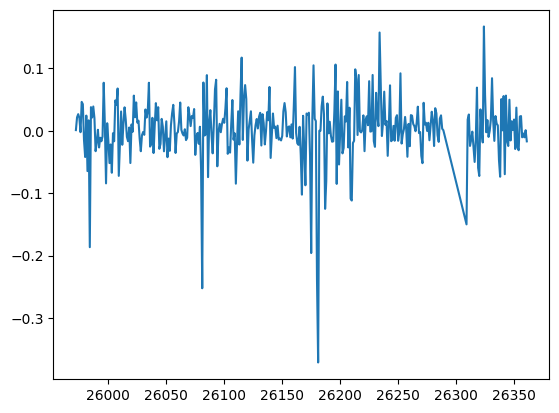

In [10]:
final_df[final_df.Ticker == "SBER"]["Close"].pct_change().plot()

In [11]:
print("!!! All columns")

for i, name in enumerate(final_df.columns):
    print(i, name)

!!! All columns
0 Date
1 Ticker
2 Open
3 High
4 Low
5 Close
6 Volume
7 sarimax_pred_1d_to_today
8 sarimax_pi_width_rel_1d
9 sarimax_pred_3d_to_today
10 sarimax_pi_width_rel_3d
11 sarimax_pred_5d_to_today
12 sarimax_pi_width_rel_5d
13 sarimax_failed
14 sma_3
15 sma_5
16 sma_7
17 sma_10
18 sma_15
19 sma_20
20 sma_30
21 sma_40
22 sma_50
23 sma_70
24 sma_100
25 sma_150
26 sma_200
27 MACD_12_26_9
28 MACDh_12_26_9
29 MACDs_12_26_9
30 ADX_14
31 ADXR_14_2
32 DMP_14
33 DMN_14
34 rsi_5
35 rsi_7
36 rsi_14
37 rsi_21
38 rsi_30
39 rsi_50
40 STOCHk_14_3_3
41 STOCHd_14_3_3
42 STOCHh_14_3_3
43 willr_5
44 willr_7
45 willr_14
46 willr_21
47 willr_30
48 atr_5
49 atr_7
50 atr_14
51 atr_21
52 BBL_20_2.0_2.0
53 BBM_20_2.0_2.0
54 BBU_20_2.0_2.0
55 BBB_20_2.0_2.0
56 BBP_20_2.0_2.0
57 bb_width_norm
58 vol_sma_5
59 relative_volume_5
60 vol_sma_7
61 relative_volume_7
62 vol_sma_14
63 relative_volume_14
64 vol_sma_20
65 relative_volume_20
66 vol_sma_30
67 relative_volume_30
68 obv_sma_5
69 obv_relative_5
70 obv_mo

In [12]:
data_with_features[final_df.columns[-15:]]

,linreg_slope_20,roc_5,roc_10,roc_20,cci_20,mfi_14,hist_vol_20,ad_line,PVO_12_26_9,PVOh_12_26_9,PVOs_12_26_9,pvt,pvt_norm,zscore_close_20,autocorr_5
200,0.014448,1.494845,19.478155,23.836478,-734.666704,81.340147,0.568036,-1.263896e+07,-10.168017,-8.845191,-1.322826,-1.189392e+07,1.858797,1.211468,-0.330951
201,0.013932,0.711267,15.758294,25.497752,-744.741403,80.821561,0.560098,-1.246442e+07,-13.024377,-9.361241,-3.663136,-1.194844e+07,1.876028,1.019029,-0.176071
202,0.013163,-3.871967,-2.103049,13.495063,-771.337086,72.646918,0.576071,-2.365486e+07,-1.669002,1.595308,-3.264309,-1.333150e+07,1.444492,0.398837,0.274966
203,0.011689,-7.616162,-3.776959,13.657264,-827.037891,72.204329,0.575254,-3.151517e+07,-4.084592,-0.656226,-3.428366,-1.350807e+07,1.343161,0.132544,0.401951
204,0.009796,-8.385469,-5.790184,14.043462,-923.508594,69.975256,0.574038,-2.917564e+07,-9.117008,-4.550914,-4.566094,-1.354466e+07,1.289749,-0.027270,0.186057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34751,-0.002392,-1.751071,-16.588235,-5.294475,8953.211413,39.879382,1.140808,1.062205e+08,0.634071,-5.724528,6.358599,-1.004608e+07,-0.996754,-1.051698,-0.157429
34752,-0.007236,-7.324455,-21.382356,5.951557,8644.967513,24.803660,1.038615,1.078915e+08,-4.980614,-9.071371,4.090757,-1.050886e+07,-1.007363,-1.256039,-0.599070
34753,-0.011595,-3.913544,-30.098623,-2.123502,9347.932677,21.645682,1.018162,1.442992e+08,-7.263149,-9.083125,1.819976,-1.134631e+07,-1.042646,-1.377150,-0.054214
34754,-0.015001,-6.909548,-27.756654,-11.044418,10206.167291,36.391845,0.970429,1.249893e+08,-11.042516,-10.289993,-0.752523,-1.176232e+07,-1.043774,-1.369742,-0.483642


In [13]:
data_with_features[[
    "Date",
    "Ticker",
"fft_abs_0",
"fft_abs_1",
"fft_abs_2",
"fft_abs_3",
"fft_abs_4",
"fft_abs_5",
"fft_abs_6",
"fft_abs_7",
"fft_abs_8",
"fft_abs_9",
"wv_L0_energy",
"wv_L0_std",
"wv_L0_mean",
"wv_L1_energy",
"wv_L1_std",
"wv_L1_mean",
"wv_L2_energy",
"wv_L2_std",
"wv_L2_mean",
"wv_L3_energy",
"wv_L3_std",
"wv_L3_mean",
"stl_trend_last",
"stl_seasonal_last",
"stl_resid_last"]
]

,Date,Ticker,fft_abs_0,fft_abs_1,fft_abs_2,fft_abs_3,fft_abs_4,fft_abs_5,fft_abs_6,fft_abs_7,...,wv_L1_mean,wv_L2_energy,wv_L2_std,wv_L2_mean,wv_L3_energy,wv_L3_std,wv_L3_mean,stl_trend_last,stl_seasonal_last,stl_resid_last
200,2019-03-19,AFKS,1114.093,59.211816,18.844395,8.173062,9.210043,9.215288,7.514949,1.630015,...,-0.007829,0.647863,0.132251,0.004426,0.448205,0.080186,0.016119,9.932618,-0.095034,0.012416
201,2019-03-26,AFKS,1121.196,63.783901,17.174153,11.277850,10.402819,2.588186,4.205892,5.657136,...,0.025397,0.870032,0.153101,-0.008628,0.373713,0.072758,-0.016857,9.868538,-0.053811,-0.091727
202,2019-04-02,AFKS,1125.000,65.684007,15.594554,14.986009,9.348995,2.959090,0.982236,5.339226,...,-0.008609,0.717062,0.139013,-0.007447,0.408249,0.076426,0.015885,9.691782,-0.318988,-0.029794
203,2019-04-09,AFKS,1126.548,66.210221,14.589617,16.271335,8.169707,4.390378,0.723042,4.038101,...,-0.009538,0.733480,0.140747,0.003733,0.372616,0.073295,-0.013758,9.246517,-0.047951,-0.028565
204,2019-04-16,AFKS,1129.904,66.480648,11.439611,16.998769,5.545658,5.081901,3.467962,5.409742,...,0.015528,0.647958,0.132314,0.002295,0.384499,0.074429,0.014112,8.942170,0.082536,0.005294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34751,2025-08-20,VTBR,11424.350,414.551851,425.111799,395.004642,237.351822,10.497694,196.048711,88.097449,...,1.188451,140.183258,1.880977,-0.500661,217.825434,1.801871,-0.066244,78.470287,0.491347,0.548366
34752,2025-08-27,VTBR,11340.940,492.222640,385.307096,365.223389,287.567129,75.355023,148.682202,15.616797,...,-0.457811,300.394421,2.831858,-0.315194,122.230415,1.349194,0.063323,78.326093,-0.702586,-1.223507
34753,2025-09-03,VTBR,11261.420,571.233798,327.805981,303.140409,362.916776,117.893231,84.437606,79.624843,...,-0.525047,214.567735,2.353751,0.508905,199.812812,1.724843,-0.084842,75.256151,-0.571156,-0.664995
34754,2025-09-10,VTBR,11181.080,650.465239,254.391067,224.601692,402.979691,118.857277,137.192453,108.581171,...,0.992535,216.781646,2.377429,0.454748,117.889528,1.323249,0.092504,73.442498,1.124030,0.403473


In [14]:
""

''